<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

# 1. 從 U-Net 到擴散模型(Diffusion Models)



U-Net 是一種卷積神經網路(CNN)，最初是為醫學影像設計的。舉例來說，我們可以將心臟的影像輸入網路中，它就能回傳一張標示出潛在癌症區域的不同影像。

我們能否使用這個過程來生成新的影像呢？這裡有個想法：如果我們在影像中加入噪訊(Noise)，然後使用 U-Net 來將影像從噪訊中分離出來呢？我們是否能夠輸入噪訊(Noise)給模型，讓它創造出可辨識的影像呢？讓我們來試試看！

#### 學習目標

本課程練習(Lab)的目標是:
* 探索 FashionMNIST 資料集
* 建構 U-Net 架構
  * 建構下採樣區塊(Down Block)
  * 建構上採樣區塊(Up Block)
* 訓練模型以移除影像中的噪訊(Noise)
* 嘗試生成服飾物品

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# Visualization tools
import graphviz
from torchview import draw_graph
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

在 PyTorch 中，我們可以透過將 [device](https://pytorch.org/docs/stable/tensor_attributes.html#torch.device) 設定為 `cuda`來在運算中使用 GPU. 函式`torch.cuda.is_available()` 將確認 PyTorch 是否能識別 GPU。

In [2]:
!nvidia-smi

Tue May 13 08:07:04 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   27C    P8    16W / 300W |      0MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## 1.1 資料集(Dataset)

為了練習生成圖像，我們將使用 [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) 資料集。FashionMNIST 被設計為圖像分類問題的「Hello World」資料集。黑白圖像的小尺寸（28 x 28 像素）也使其成為圖像生成的絕佳起點。

FashionMNIST 包含在 [Torchvision](https://pytorch.org/vision/stable/index.html)，這是一個與 PyTorch 相關的電腦視覺(Computer Vision)函式庫。當我們下載資料集時，我們可以傳遞一個我們想要應用於圖像的所有[transformations](https://pytorch.org/vision/stable/transforms.html) 列表(list)。目前，我們將使用  [ToTensor](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor) 將圖像轉換為張量(Tensor)，以便我們可以使用神經網路(Neural Network)處理圖像。這將自動將像素值從 [0, 255]縮放到[0, 1]。它還會將維度從 [高度 x 寬度 x 通道(channel)] 重新排列為 [通道(channel) x 高度 x 寬度]。

In [4]:
train_set = torchvision.datasets.FashionMNIST(
    "./data/", download=True, transform=transforms.Compose([transforms.ToTensor()])
)
NUM_CLASSES = 10

100%|██████████| 26421880/26421880 [00:01<00:00, 13740289.36it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 331598.17it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6060482.52it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 38765308.78it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



我們可以使用以下程式碼來取樣一些圖片：

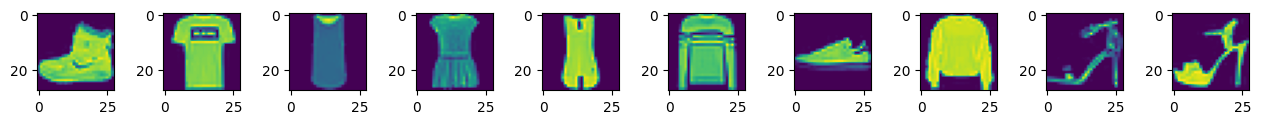

In [5]:
# Adjust for display; high w/h ratio recommended
plt.figure(figsize=(16, 1))

def show_images(dataset, num_samples=10):
    for i, img in enumerate(dataset):
        if i == num_samples:
            return
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(torch.squeeze(img[0]))

show_images(train_set)

讓我們為我們的資料集設定一些常數(constants)。在使用 U-Net 架構時，常見的做法是透過[最大池化(Max Pooling)](https://paperswithcode.com/method/max-pooling)持續將特徵圖(Feature Map)的尺寸減半。接著，再使用[轉置卷積(Transposed Convolution)](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)將特徵圖的尺寸加倍。 為了在我們在 U-Net 向下和向上移動時保持圖片尺寸的一致性，圖片大小最好能被 2 多次整除。

In [6]:
IMG_SIZE = 16 # Due to stride and pooling, must be divisible by 2 multiple times
IMG_CH = 1 # Black and white image, no color channels
BATCH_SIZE = 128

現在我們已經定義好目標影像尺寸，讓我們建立一個函式來載入資料並將其轉換成目標尺寸。我們將要加入影像的隨機噪訊(Noise)會從中[標準常態分佈(Standard Normal Distribution)](https://mathworld.wolfram.com/NormalDistribution.html)取樣，這表示68%的噪訊像素值會落在-1到1之間。我們同樣會將影像值縮放到-1到1之間。

這也是一個適合套用隨機影像增強(Random Image Augmentation)的好時機。目前，我們先從[隨機水平翻轉(RandomHorizontalFlip)](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip)開始。我們不會使用[隨機垂直翻轉(RandomVerticalFlip)](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomVerticalFlip.html#torchvision.transforms.RandomVerticalFlip)，因為這會產生上下顛倒的影像。 

In [7]:
def load_fashionMNIST(data_transform, train=True):
    return torchvision.datasets.FashionMNIST(
        "./",
        download=True,
        train=train,
        transform=data_transform,
    )


def load_transformed_fashionMNIST():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms)
    train_set = load_fashionMNIST(data_transform, train=True)
    test_set = load_fashionMNIST(data_transform, train=False)
    return torch.utils.data.ConcatDataset([train_set, test_set])

In [8]:
data = load_transformed_fashionMNIST()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 13825395.39it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 327877.01it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6082388.02it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15067883.46it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



## 1.2 U-Net架構(U-Net Architecture)

首先，讓我們定義U-Net架構的不同組件。主要是`下採樣區塊(DownBlock)`和`上採樣區塊(UpBlock)`。

### 1.2.1 下採樣區塊(Down Block)

`下採樣區塊(DownBlock)`是一個典型的卷積神經網路(CNN)。如果你是PyTorch新手，且具有Keras/TensorFlow的使用背景，以下的內容比較類似[函式API(Functional API)](https://keras.io/guides/functional_api/) 而不是[循序模型(Sequential Model)](https://keras.io/guides/sequential_model/)。我們稍後會使用[殘差連接(Residual)](https://stats.stackexchange.com/questions/321054/what-are-residual-connections-in-rnns) 和跳躍連接(Skip Connection)。循序模型無法支援這些類型的連接，但函數式模型可以。

在我們的`__init__` 函式中，我們會將各種神經網路運算指派給類別變數(class variables):
* [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)對輸入進行卷積運算。`in_ch`是我們要進行卷積的通道數，而`out_ch`是輸出通道數，這與用於卷積(convolution)的核心過濾器(kernel filters)數量相同。在U-Net架構中，通道數(channels )通常會隨著模型往下層移動而增加。
* [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) 是卷積核心的活化函數(Activation Function)。
* [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) 對神經元層套用 [批次正規化(batch normalization)](https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338)。ReLU沒有可學習的參數，所以我們可以將相同的函數套用到多個層，效果會與使用多個ReLU函數相同。批次正規化具有可學習的參數，重複使用這個函數可能會產生意外的效果。
* [MaxPool2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)是我們用來在網路向下移動時減少特徵圖(Feature Map)大小的方法。雖然可以透過卷積達到這個效果，但最大池化在U-Net中更常被使用。

在 `forward`方法中，我們描述了各種函數應該如何應用於輸入。到目前為止，運算是按照以下順序進行：
* `Conv2d`
* `BatchNorm2d`
* `ReLU`
* `Conv2d`
* `BatchNorm2d`
* `ReLU`
* `MaxPool2d`

In [9]:
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        kernel_size = 3
        stride = 1
        padding = 1

        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

### 1.2.2 上採樣區塊(Up Block)

當`「下採樣區塊(DownBlock)」`縮小我們的特徵圖(Feature Map)尺寸時，`「上採樣區塊(UpBlock)」`則將其尺寸加倍。這是透過[轉置卷積(ConvTranspose2d)](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)來實現的。我們可以使用與`「下採樣區塊(DownBlock)」`幾乎相同的架構，但我們會將conv2替換為convT。轉置(transpose)的`步長(stride)`設為2，搭配適當的`填充(padding)`，就能實現尺寸加倍。

讓我們透過以下的程式碼區塊(cell)來進行練習。我們已經設置了一個測試範例，建立一個值全為`1`的測試影像。



In [10]:
ch, h, w = 1, 3, 3
x = torch.ones(1, ch, h, w)
x

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

我們可以使用恆等核心(identity kernel)來觀察`轉置卷積(conv_transpose2d)`如何改變輸入影像。恆等核心(identity kernel)只有一個值為`1`。當用於卷積(convolution)時，輸出將與輸入相同。

試著更改`步長(stride)`、`填充(padding)`和`輸出填充(output_padding)`。結果是否符合你的預期？


In [11]:
kernel = torch.tensor([[1.]])  # Identity kernel
kernel = kernel.view(1, 1, 1, 1).repeat(1, ch, 1, 1) # Make into a batch

output = F.conv_transpose2d(x, kernel, stride=1, padding=0, output_padding=0)[0]
output

tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])

核心(kernel)大小也會影響輸出特徵圖(Feature Map)的尺寸。試著更改`核心大小(kernel_size)`。注意到當核心大小增加時，輸出影像如何擴展？這與一般卷積(convolution)相反，在一般卷積中，較大的核心大小會減少輸出特徵圖(Feature Map)的尺寸。


In [12]:
kernel_size = 3
kernel = torch.ones(1, 1, kernel_size, kernel_size)

output = F.conv_transpose2d(x, kernel, stride=1, padding=0, output_padding=0)[0]
output

tensor([[[1., 2., 3., 2., 1.],
         [2., 4., 6., 4., 2.],
         [3., 6., 9., 6., 3.],
         [2., 4., 6., 4., 2.],
         [1., 2., 3., 2., 1.]]])


另一個有趣的差異：我們將輸入通道(channel)數量乘以2。這是為了配合跳躍連接(skip connections)。我們將把`「上採樣區塊(UpBlock)」`對應的`「下採樣區塊(DownBlock)」`的輸出與`「上採樣區塊(UpBlock)」`的輸入進行串接()。



<center><img src="images/FMUNet.png" width="600" /></center>

若輸入特徵圖(Feature Map)的大小為 x，則輸出大小為:

`new_x = (x - 1) * stride + kernel_size - 2 * padding + out_padding`


若步長(Stride)為 2 且外填充(out_padding)為 1，為了將輸入特徵圖(Feature Map)的大小加倍：

`kernel_size = 2 * padding + 1`

操作方式與之前幾乎相同，但有兩個差異:
* `ConvTranspose2d` - 使用轉置卷積(Transposed Convolution)而非卷積(Convolution)
* `BatchNorm2d`
* `ReLU`
* `Conv2d`
* `BatchNorm2d`
* `ReLU`
* ~~`MaxPool2d`~~ - 向上縮放(Scaling up)而非向下縮放

In [13]:
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        # Convolution variables
        kernel_size = 3
        stride = 1
        padding = 1

        # Transpose variables
        strideT = 2
        out_paddingT = 1

        super().__init__()
        # 2 * in_chs for concatednated skip connection
        layers = [
            nn.ConvTranspose2d(2 * in_ch, out_ch, kernel_size, strideT, padding, out_paddingT),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

### 1.2.3 完整的U-Net

終於到了將所有部分組合在一起的時候！以下是我們完整的`「U-Net」`模型。

在 `__init__` 函式中，我們可以用`「down_chs」`定義U-Net每個步驟的通道(channel)數量。目前的預設值是「(16, 32, 64)」，這表示資料在模型中移動時的當前維度為：

* input: 1 x 16 x 16
* down0: 16 x 16 x 16
  * down1: 32 x 8 x 8
    * down2: 64 x 4 x 4
      * dense_emb: 1024
    * up0: 64 x 4 x 4
  * up1: 64 x 8 x 8
* up2: 32 x 16 x 16
* out: 1 x 16 x 16

在`forward`類別方法(class method )中，我們終於要加入跳躍連接(skip connections)。對於U-Net中的每個下採樣步驟，我們會追蹤每個「`下採樣區塊(DownBlock)`」的輸出。然後，當我們通過「`上採樣區塊(UpBlock)`」時，我們會將前一個「`上採樣區塊(UpBlock)`」的輸出與其對應的「`下採樣區塊(DownBlock)`」進行[串接(concatenate)](https://pytorch.org/docs/stable/generated/torch.cat.html)。


In [14]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_ch = IMG_CH
        down_chs = (16, 32, 64)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)

        # Inital convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_ch, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_ch, 3, 1, 1),
        )

    def forward(self, x):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0, down2)
        up2 = self.up2(up1, down1)
        return self.out(up2)

In [15]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  234977


讓我們使用 [torchview](https://github.com/mert-kurttutan/torchview) 來驗證模型架構。如果我們有三個`down_chs`，應該會有兩個`DownBlock`，每個轉換一個。同樣地，應該會有兩個`UpBlock`。我們還應該檢查是否有一個跳躍連接(Skip Connection)。U型網路(U-Net)的「底部」不需要跳躍連接(Skip Connection)，所以每個 `UpBlock`減一就是跳躍連接(Skip Connection)的數量。

最後，輸出維度是否與輸入維度相同？


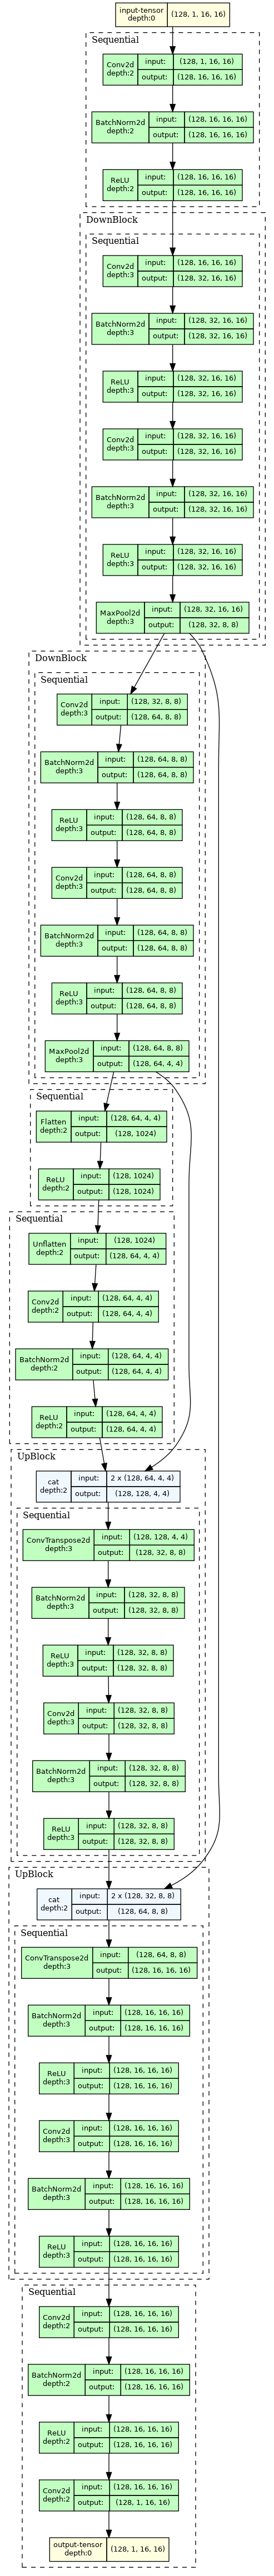

In [16]:
graphviz.set_jupyter_format('png')
model_graph = draw_graph(
    model,
    input_size=(BATCH_SIZE, IMG_CH, IMG_SIZE, IMG_SIZE),
    device='meta',
    expand_nested=True
)
model_graph.resize_graph(scale=1.5)
model_graph.visual_graph

在 [PyTorch 2.0](https://pytorch.org/get-started/pytorch-2.0/) 中，我們可以編譯模型來加快訓練速度。它會將操作列表(list of operations)送到我們的圖形處理器(GPU)，這樣它就可以像組裝線(Assembly Line)一樣將這些操作應用到我們的輸入。在[此處](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html).閱讀更多相關資訊



In [17]:
model = torch.compile(UNet().to(device))

## 1.3 訓練

讓我們嘗試在圖像中加入噪訊(Noise)，看看我們的 U型網路(U-Net)模型是否能過濾掉它。我們可以定義一個參數 `beta` 來表示圖像中噪訊(Noise)與原始圖像的百分比。我們可以使用 `alpha` 來表示 `beta` 的[補數](https://brilliant.org/wiki/probability-by-complement/)。



In [18]:
def add_noise(imgs):
    dev = imgs.device
    percent = .5 # Try changing from 0 to 1
    beta = torch.tensor(percent, device=dev)
    alpha = torch.tensor(1 - percent, device=dev)
    noise = torch.randn_like(imgs)
    return alpha * imgs + beta * noise

接下來，我們將定義損失函數(Loss Function)為原始圖像和預測圖像之間的[均方誤差(Mean Squared Error)](https://developers.google.com/machine-learning/glossary#mean-squared-error-mse) 。


In [19]:
def get_loss(model, imgs):
    imgs_noisy = add_noise(imgs)
    imgs_pred = model(imgs_noisy)
    return F.mse_loss(imgs, imgs_pred)

為了顯示模型的輸出結果，我們需要在CPU上將其轉換回圖像格式。

In [20]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()))


為了觀察訓練過程中的改進情況，我們可以使用[子圖(subplots)](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html)來比較`「原始(Original)」`圖像、`「加入噪訊(Noise Added)」`的圖像，以及`「預測原始(Predicted Original)」`圖像。

[@torch.no_grad](https://pytorch.org/docs/stable/generated/torch.no_grad.html) 將在訓練期間跳過使用此函數來計算梯度(Gradient)。



In [21]:
@torch.no_grad()
def plot_sample(imgs):
    # Take first image of batch
    imgs = imgs[[0], :, :, :]
    imgs_noisy = add_noise(imgs[[0], :, :, :])
    imgs_pred = model(imgs_noisy)

    nrows = 1
    ncols = 3
    samples = {
        "Original" : imgs,
        "Noise Added" : imgs_noisy,
        "Predicted Original" : imgs_pred
    }
    for i, (title, img) in enumerate(samples.items()):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(title)
        show_tensor_image(img)
    plt.show()

終於到了關鍵時刻！是時候訓練我們的模型並觀察其改進情況了。

Epoch 0 | Step 000 Loss: 1.241747498512268 


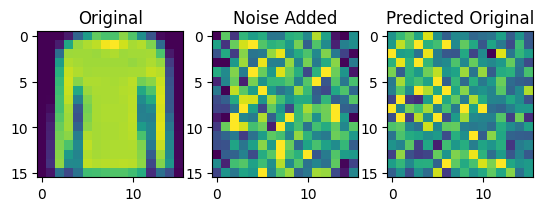

Epoch 0 | Step 100 Loss: 0.2118656486272812 


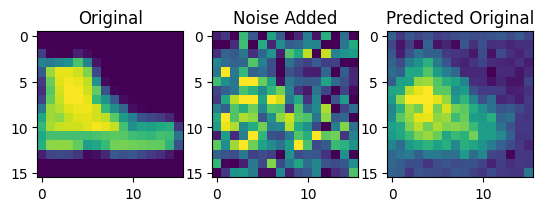

Epoch 0 | Step 200 Loss: 0.10805745422840118 


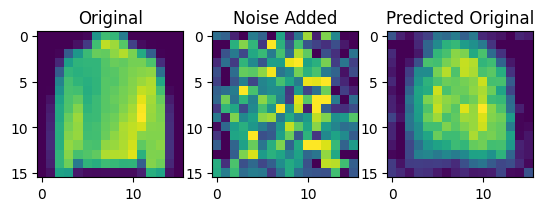

Epoch 0 | Step 300 Loss: 0.07952751964330673 


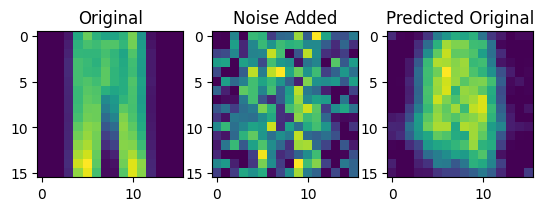

Epoch 0 | Step 400 Loss: 0.06860987842082977 


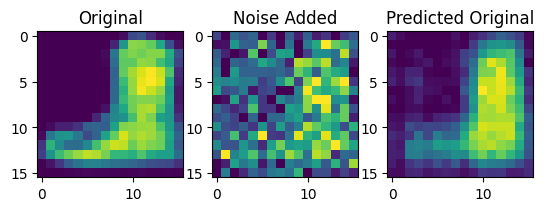

Epoch 0 | Step 500 Loss: 0.06364870071411133 


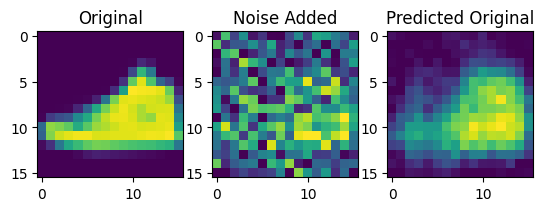

Epoch 1 | Step 000 Loss: 0.06498156487941742 


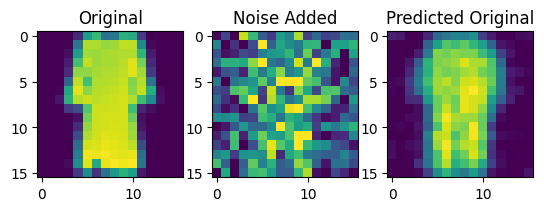

Epoch 1 | Step 100 Loss: 0.06104697287082672 


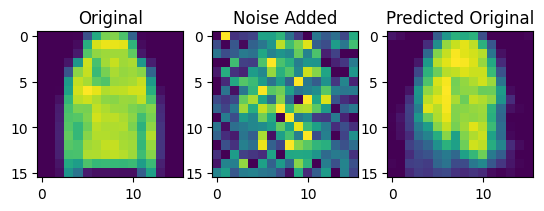

Epoch 1 | Step 200 Loss: 0.05704614892601967 


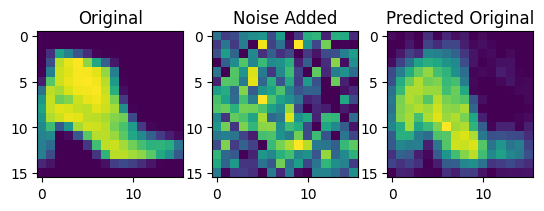

Epoch 1 | Step 300 Loss: 0.04986656829714775 


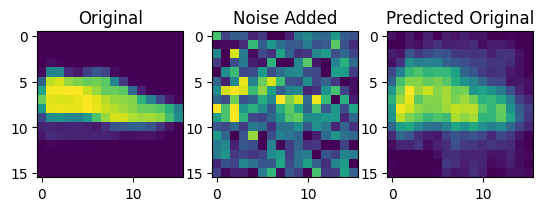

Epoch 1 | Step 400 Loss: 0.054030634462833405 


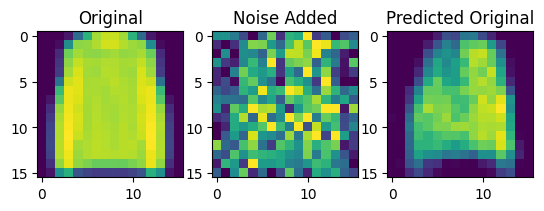

Epoch 1 | Step 500 Loss: 0.05209091305732727 


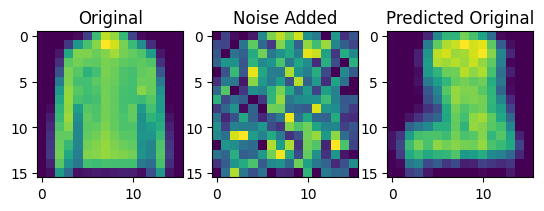

In [22]:
optimizer = Adam(model.parameters(), lr=0.0001)
epochs = 2

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        images = batch[0].to(device)
        loss = get_loss(model, images)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | Step {step:03d} Loss: {loss.item()} ")
            plot_sample(images)

在預測圖像中有一些噪訊(Noise)，但它仍然能夠不錯地提取出原始服裝。

現在，當模型面對純噪訊(Noise)時表現如何？它能創造出可信的新圖像嗎？

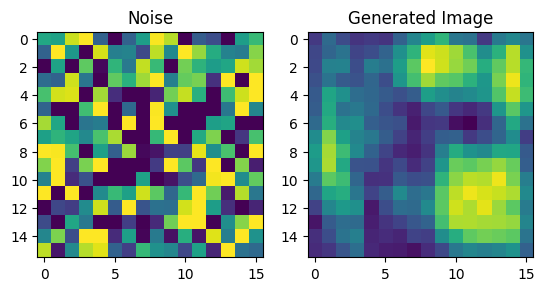

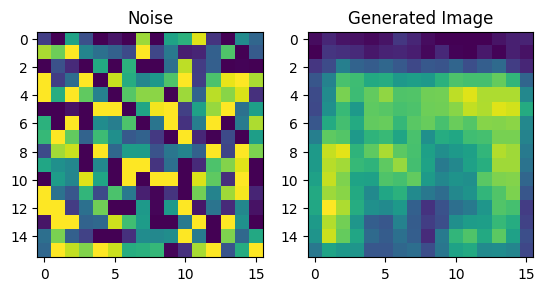

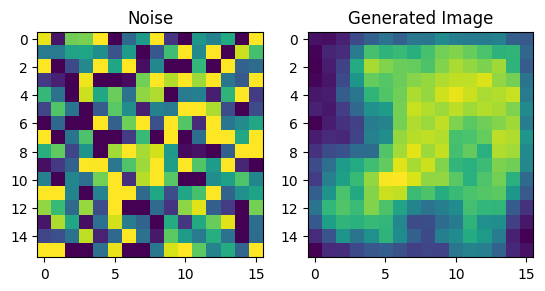

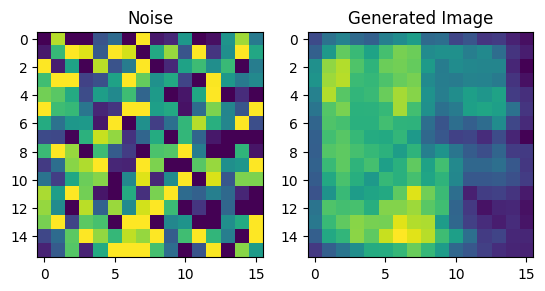

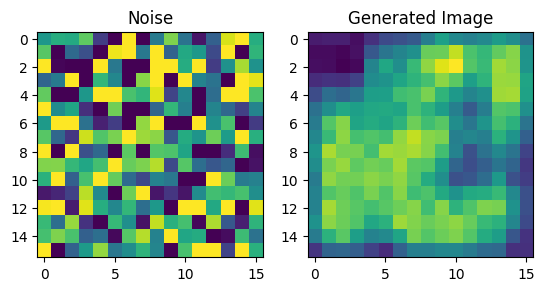

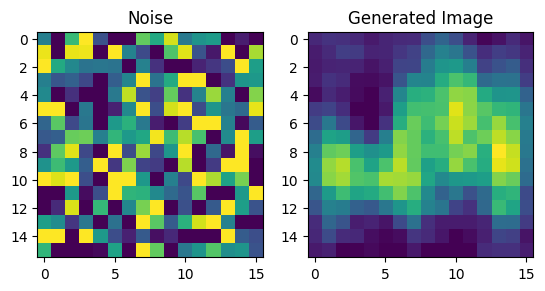

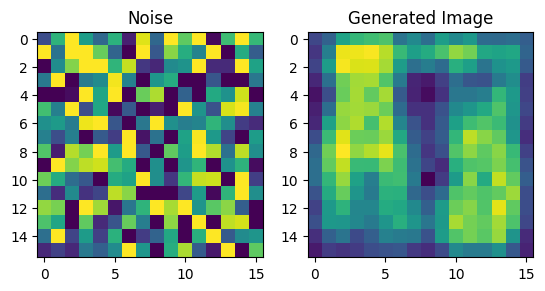

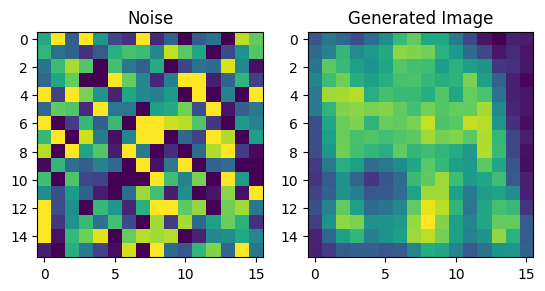

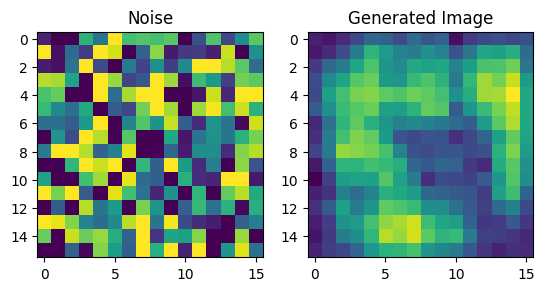

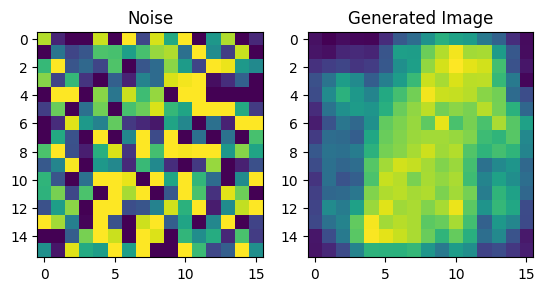

In [23]:
model.eval()
for _ in range(10):
    noise = torch.randn((1, IMG_CH, IMG_SIZE, IMG_SIZE), device=device)
    result = model(noise)
    nrows = 1
    ncols = 2
    samples = {
        "Noise" : noise,
        "Generated Image" : result
    }
    for i, (title, img) in enumerate(samples.items()):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(title)
        show_tensor_image(img)
    plt.show()

## 下一步

嗯，這些圖像看起來更像是墨跡測驗圖像而不是服裝。在下一個課程練習(Lab)中，我們將改進這個技術來創造出更容易辨識的圖像。

在繼續之前，請透過執行下方的程式碼區塊(Cell)重新啟動jupyter核心。這將防止在後續的課程練習(Lab)中出現記憶體問題。

In [24]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>